In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import dynesty as dyn
from scipy.special import ndtri
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde

In [2]:
grbparam = pd.read_csv('GRBPARAM.csv', index_col=0)
# [grbname.replace('.txt','')]

In [3]:
param_ranges_NULL = [(0, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_lin = [(0, 1e20), (0, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]
param_range_quad = [(0, 1e15), (0, 5000), (-3, 10), (-10, 3), (0, 3), (0, 4)]


grbname = 'GRB210619B.txt'
grbname_wtht_ext = grbname.replace('.txt','')


arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]

#Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
nburnin = 1000 #burn-in
H0=70 #km/s/Mpc Taken from Sir's Code



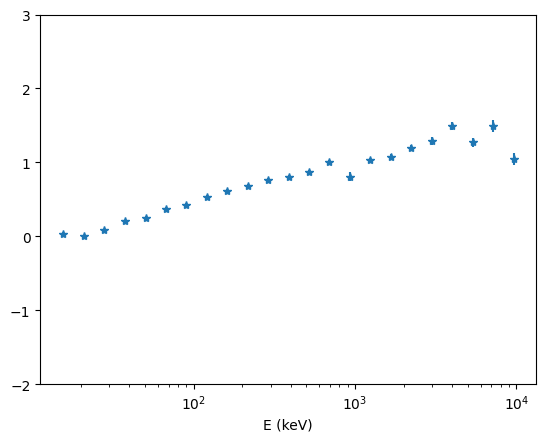

In [4]:
# plt.plot(arr[:,0], arr[:,1], '*')
plt.errorbar(arr[:,0], arr[:,1], yerr=arr[:,2], fmt='*')
plt.xlabel('E (keV)')
plt.xscale('log')
plt.ylim(-2, 3)
plt.show()

In [5]:
def MODEL_delta_t_intrinsic(E, log_Eb, alpha1, alpha2, mu, zeta):
    
    E0b = (E - E0)/(10**log_Eb)
    return zeta * (E0b ** alpha1) * (1 + E0b ** ((alpha2 - alpha1)*mu))/2


def int_over_red_shift(z, n):
    '''
    Integrate over redshift
    
    Parameters
    ----------
    z : float
        Redshift
    n : float
        LIV Polynomial power        
    '''
    
    
    #    f = lambda x: ((1+x)**n)/h_gp(x)
    f = lambda x: ((1+x)**n)/np.sqrt(0.3*(1+x)**3 + 0.7)
    return quad(f, 0, z)[0]


K_z1 = int_over_red_shift(z_com,1)
K_z2 = int_over_red_shift(z_com,2)
	
def linear(E, z, logE_qg, logEb, alpha1, alpha2, mu, zeta):
    K_z= np.asarray(K_z1)
    # return (1+z)*tau*(Erest - E0rest) + (-(10**14)/(H0*3.24))*((Erest - E0rest)*K_z/(E_qg*(1+z)))
    return MODEL_delta_t_intrinsic(E, logEb, alpha1, alpha2, mu, zeta) + (-(10**14)/(H0*3.24))*((E - E0)*K_z/((10**logE_qg)*(1+z)))

def quadratic(E, z, logE_qg, logEb, alpha1, alpha2, mu, zeta):
    E_0=E0rest/(1+z)
    Eres=E/(1+z)
    K_z = np.asarray(K_z2)
    # return (1+z)*tau*(Erest**2 - E0rest**2) + (-1.5*(10**8)/(H0*3.24))*((E**2 - E_0**2)*K_z/E_qg**2)
    return MODEL_delta_t_intrinsic(E, logEb, alpha1, alpha2, mu, zeta) + (-1.5*(10**8)/(H0*3.24))*((Eres**2 - E_0**2)*K_z/(10**logE_qg)**2)

In [6]:
def loglklhood_null_HP(theta):
    log_Eb, alpha1, alpha2, mu, zeta = theta
    
    if alpha1 >= alpha2:
        model = MODEL_delta_t_intrinsic(x, log_Eb, alpha1, alpha2, mu, zeta)
        return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    return -np.inf

def loglklhood_LIV_lin(theta1):
    
    logE_qg, logEb, alpha1, alpha2, mu, zeta = theta1
    
    if alpha1 >= alpha2:
        model = linear(x, z_com, logE_qg, logEb, alpha1, alpha2, mu, zeta)    
        return sum(stats.norm.logpdf(*rgs) for rgs in zip(y,model,yerr))
    return -np.inf

def loglklhood_LIV_quad(theta2):
    
    logE_qg, logEb, alpha1, alpha2, mu, zeta = theta2
    if alpha1 >= alpha2:
        model = linear(x, z_com, logE_qg, logEb, alpha1, alpha2, mu, zeta)    
        return sum(stats.norm.logpdf(*rgs) for rgs in zip(y,model,yerr))
    return -np.inf

In [7]:
def prior_transform(theta):
    log_Eb, alpha1, alpha2, mu, zeta = theta

    log_Eb_max = np.log10(5000) + 3
    alpha1_min, alpha1_max = -3.0, 10.0
    alpha2_min, alpha2_max = -10.0, 3.0
    mu_max = 3.0
    zeta_max = 4.0

    log_Eb = log_Eb_max * log_Eb
    alpha1 = alpha1_min + (alpha1_max - alpha1_min) * alpha1
    alpha2 = alpha2_min + (alpha2_max - alpha2_min) * alpha2
    mu = mu_max * mu
    zeta = zeta_max * zeta
    
    return [log_Eb, alpha1, alpha2, mu, zeta]


def prior_transform_LIV_lin(theta1):
    log_E_qg, log_Eb, alpha1, alpha2, mu, zeta = theta1

    log_E_qg_max = np.log10(1e20) + 9
    log_Eb_max = np.log10(5000)  + 3
    alpha1_min, alpha1_max = -3.0, 10.0
    alpha2_min, alpha2_max = -10.0, 3.0
    mu_max = 3.0
    zeta_max = 4.0

    
    log_E_qg = log_E_qg_max * log_E_qg
    log_Eb = log_Eb_max * log_Eb
    alpha1 = alpha1_min + (alpha1_max - alpha1_min) * alpha1
    alpha2 = alpha2_min + (alpha2_max - alpha2_min) * alpha2
    mu = mu_max * mu
    zeta = zeta_max * zeta

    return [log_E_qg, log_Eb, alpha1, alpha2, mu, zeta]


def prior_transform_LIV_quad(theta2):
    log_E_qg, log_Eb, alpha1, alpha2, mu, zeta = theta2

    log_E_qg_max = np.log10(1e15) + 9
    log_Eb_max = np.log10(5000) + 3  
    alpha1_min, alpha1_max = -3.0, 10.0
    alpha2_min, alpha2_max = -10.0, 3.0
    mu_max = 3.0
    zeta_max = 4.0

    
    log_E_qg = log_E_qg_max * log_E_qg
    log_Eb = log_Eb_max * log_Eb
    alpha1 = alpha1_min + (alpha1_max - alpha1_min) * alpha1
    alpha2 = alpha2_min + (alpha2_max - alpha2_min) * alpha2
    mu = mu_max * mu
    zeta = zeta_max * zeta

    return [log_E_qg, log_Eb, alpha1, alpha2, mu, zeta]



In [8]:
nlive = 1024
ndim_NULL = 5
ndim_LIV = 6

# NULL hypothesis

with dyn.pool.Pool(12, loglklhood_null_HP, prior_transform) as Pool:
    sampler0 = dyn.NestedSampler(loglklhood_null_HP, prior_transform, ndim=ndim_NULL, bound='multi', sample='rwalk', pool=Pool, nlive=nlive)
    sampler0.run_nested( dlogz=0.1)
    results0 = sampler0.results
    
Pool.close()
print(results0.summary())



with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_results_null_logE.pkl', 'wb') as f:
    pickle.dump(results0, f)

with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_sampler_null_logE.pkl', 'wb') as f:
    pickle.dump(sampler0, f)

/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
0it [00:00, ?it/s]

/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
196it [00:00, 1958.15it/s, bound: 0 | nc: 2 | ncall: 1247 | eff(%): 15.718 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.100]/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
392it [00:00, 1823.05it/s, bound: 0 | nc: 2 | ncall: 1522 | eff(%): 25.756 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.100]/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x*

Summary
nlive: 1024
niter: 18995
ncall: 421333
eff(%):  4.751
logz: -212.095 +/-  0.153
None


In [9]:
# Linear LIV
with dyn.pool.Pool(12, loglklhood_LIV_lin, prior_transform_LIV_lin) as Pool:
    sampler1 = dyn.NestedSampler(loglklhood_LIV_lin, prior_transform_LIV_lin, ndim=ndim_LIV, bound='multi', sample='rwalk', pool=Pool, nlive=nlive)
    sampler1.run_nested( dlogz=0.1)
    results1 = sampler1.results

Pool.close()
print(results1.summary())


with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_results_LIV_lin_logE.pkl', 'wb') as f:
    pickle.dump(results1, f)

with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_sampler_LIV_lin_logE.pkl', 'wb') as f:
    pickle.dump(sampler1, f)

/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountere

Summary
nlive: 1024
niter: 26429
ncall: 631172
eff(%):  4.350
logz: -75.704 +/-  0.183
None


In [10]:
# Quadratic LIV
with dyn.pool.Pool(12, loglklhood_LIV_quad, prior_transform_LIV_quad) as Pool:
    sampler2 = dyn.NestedSampler(loglklhood_LIV_quad, prior_transform_LIV_quad, ndim=ndim_LIV, bound='multi', sample='rwalk', pool=Pool, nlive=nlive)
    sampler2.run_nested( dlogz=0.1)
    results2 = sampler2.results
    
Pool.close()
print(results2.summary())

with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_results_LIV_quad_logE.pkl', 'wb') as f:
    pickle.dump(results2, f)
    

with open(os.getcwd() + f'/pickle/{grbname_wtht_ext}_sampler_LIV_quad_logE.pkl', 'wb') as f:
    pickle.dump(sampler2, f)

/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/darkwake/.local/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:296: RuntimeWarning: overflow encountere

Summary
nlive: 1024
niter: 25987
ncall: 621810
eff(%):  4.344
logz: -75.265 +/-  0.182
None


In [11]:
def smooth_plot(results, figname, labels=["logE_qg", "logEb", "alpha1", "alpha2", "mu", "zeta"]):
    weights = np.exp(results.logwt - results.logz[-1])
    samples = dyn.utils.resample_equal(  results.samples, weights)
    
    fig = corner(samples, weights=weights, labels=labels, levels=[0.68, 0.9], show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'density': True})
    ndim =samples.shape[1]
    for axidx, samps in zip([i*(ndim+1) for i in range(ndim)],samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
    plt.savefig(os.getcwd() + '/outputs/' + figname + '.png')
    plt.show()

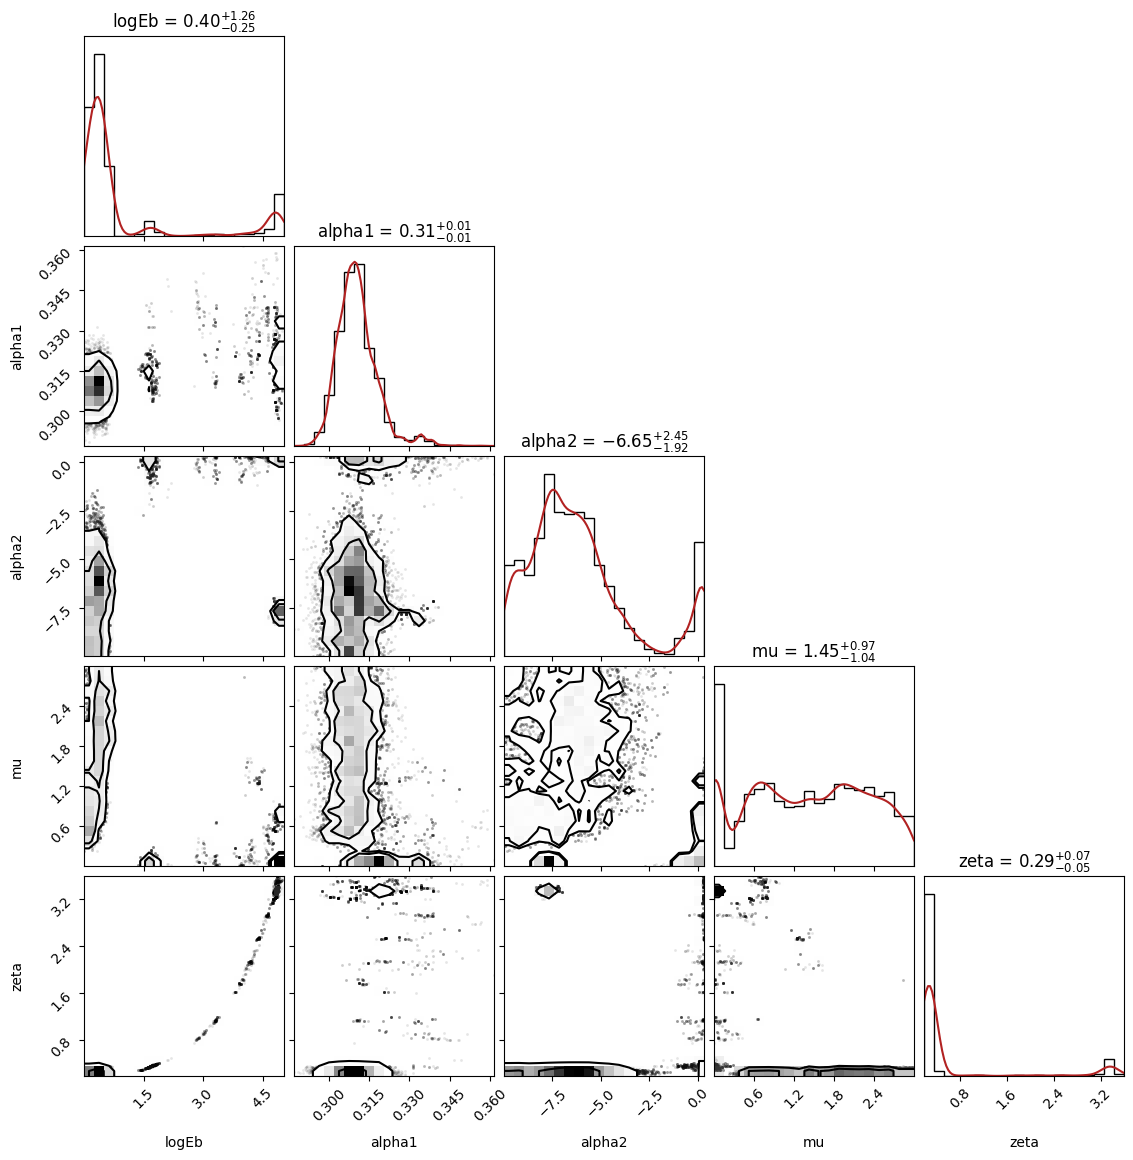

In [12]:
smooth_plot(results0, figname=grbname_wtht_ext + 'null_HP_logE', labels=["logEb", "alpha1", "alpha2", "mu", "zeta"])

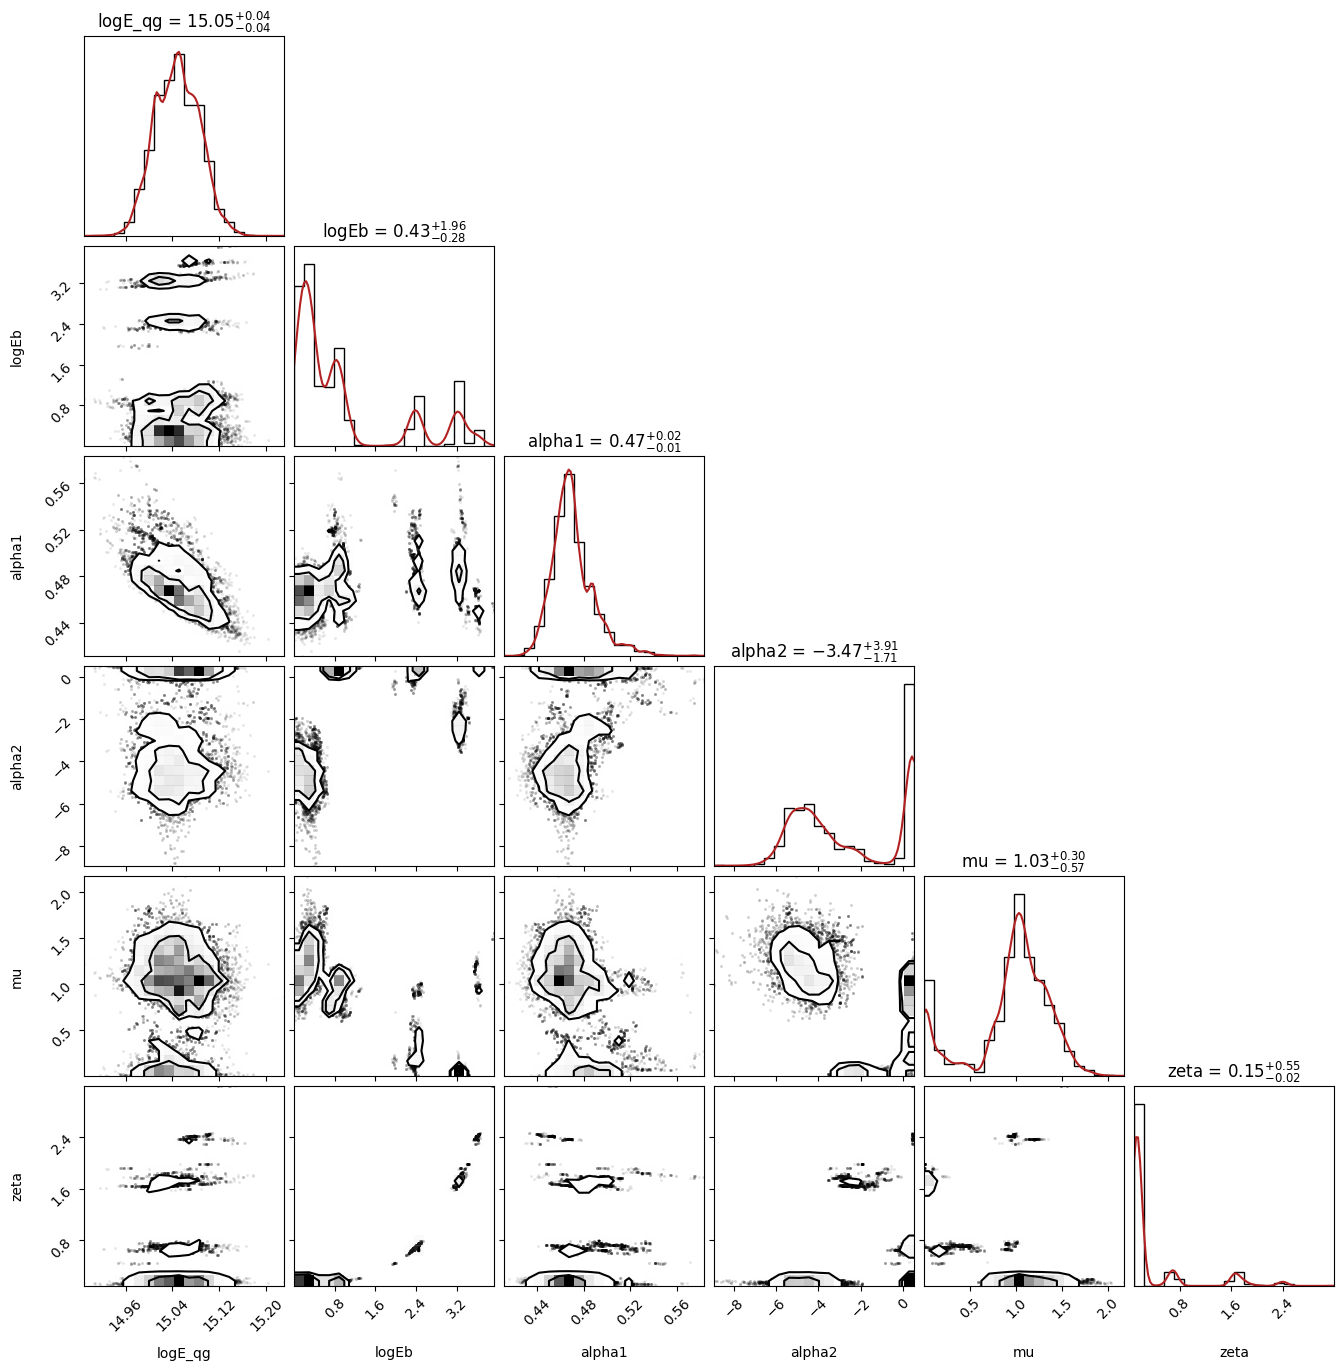

In [13]:
smooth_plot(results1, figname=grbname_wtht_ext + 'LIV_lin' + '_smooth_logE')

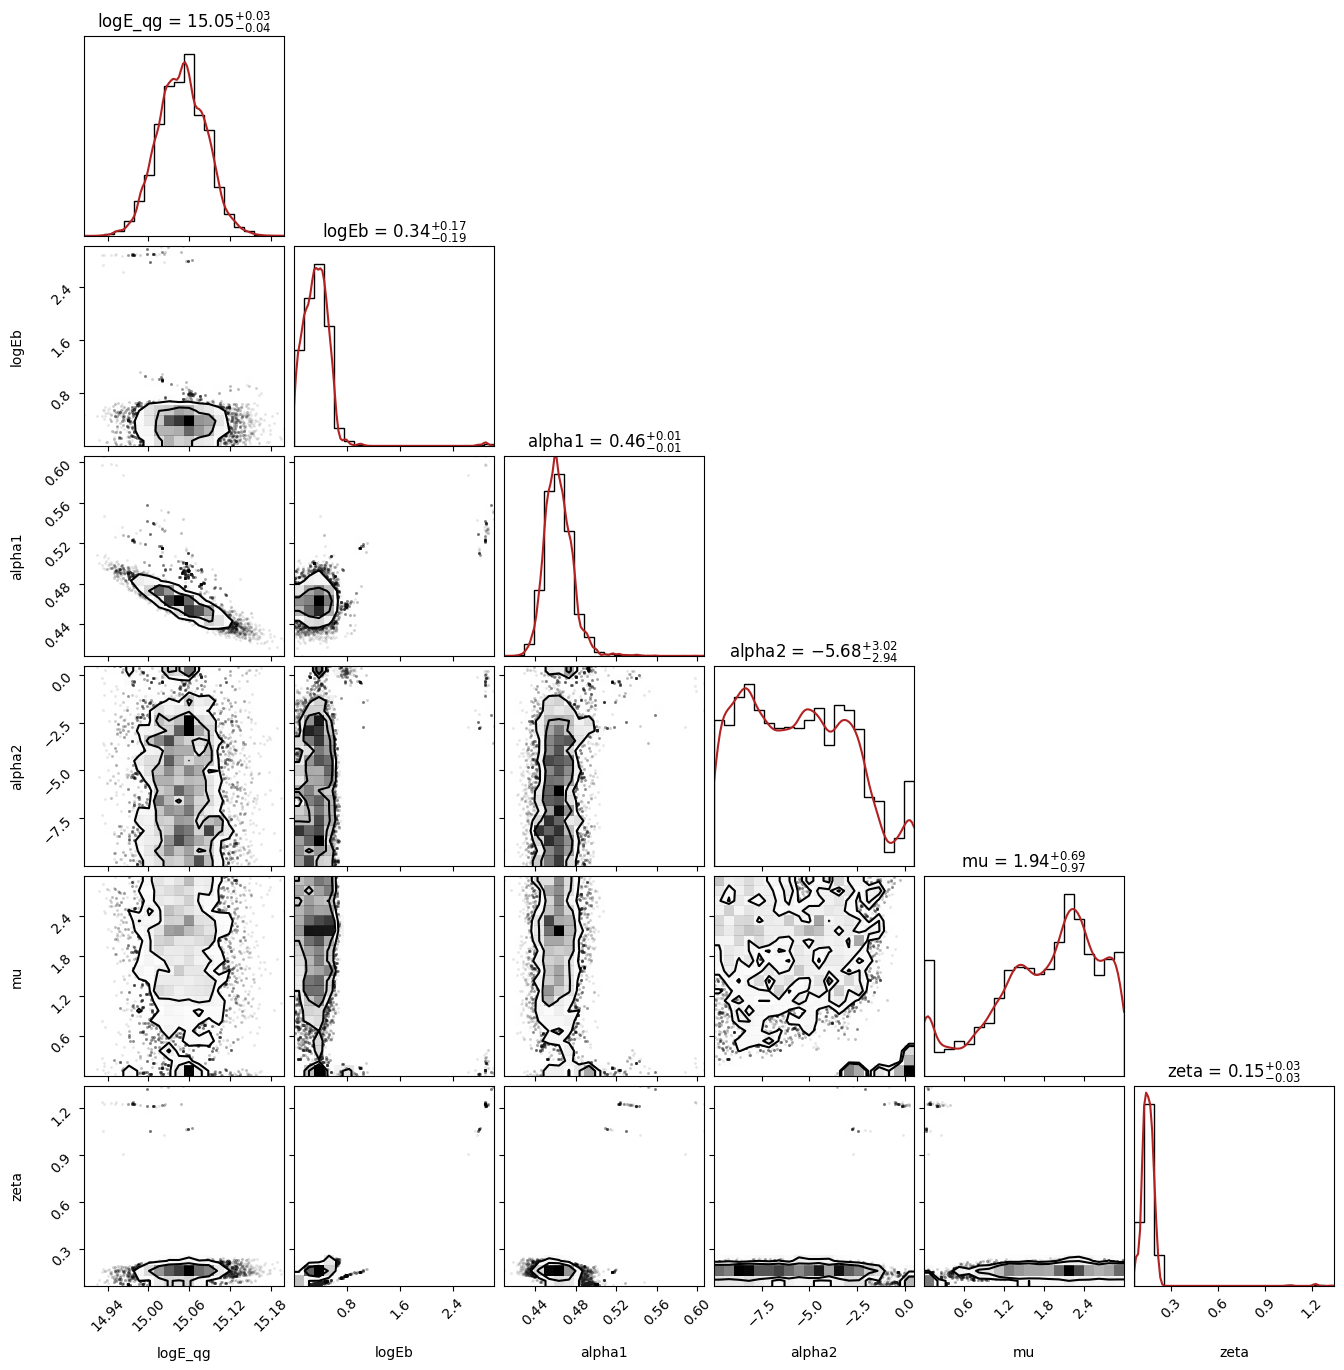

In [14]:
smooth_plot(results2, figname=grbname_wtht_ext + 'LIV_quad' + '_smooth_logE')

In [15]:
# Eb, alpha1, alpha2, mu, zeta = theta2
nplot = 100
E = np.linspace(min(Erest), max(Erest), nplot)
samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
samples0 = np.median(samples0, axis=0)

samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
samples1 = np.median(samples1, axis=0)

samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
samples2 = np.median(samples2, axis=0)

null_fit = [MODEL_delta_t_intrinsic(E[i], samples0[0], samples0[1], samples0[2], samples0[3], samples0[4]) for i in range(nplot)]
liv_lin_fit = [linear(E[i], z_com, samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5]) for i in range(nplot)]
liv_quad_fit = [quadratic(E[i], z_com, samples1[0], samples1[1], samples1[2], samples1[3], samples1[4], samples1[5]) for i in range(nplot)]

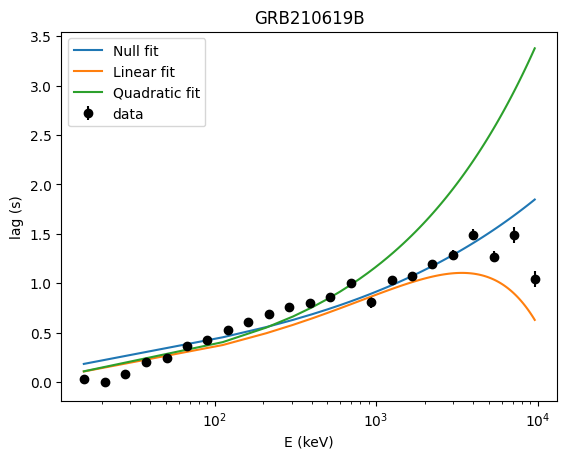

In [16]:
plt.errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
plt.plot(E, null_fit, label='Null fit')
plt.plot(E, liv_lin_fit,label='Linear fit')
plt.plot(E, liv_quad_fit, label='Quadratic fit')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grbname_wtht_ext)
plt.savefig(os.getcwd() + '/outputs/' + grbname_wtht_ext + '_fit_logE.png', facecolor='white')
plt.show()

In [17]:
bayes_factor_lin = np.exp(results1.logz[-1] - results0.logz[-1])
bayes_factor_quad = np.exp(results2.logz[-1] - results0.logz[-1])

print('Bayes factor for linear LIV model: ', bayes_factor_lin)
print('Bayes factor for quadratic LIV model: ', bayes_factor_quad)

Bayes factor for linear LIV model:  1.7131372000619924e+59
Bayes factor for quadratic LIV model:  2.6572378150183117e+59


In [22]:
print(results1.logz[-1], results2.logz[-1], results0.logz[-1])

-75.70428529288233 -75.26532443459642 -212.09513208910528


In [23]:
print(results1.logzerr[-1], results2.logzerr[-1], results0.logzerr[-1])

0.18314232981046638 0.18185585578974456 0.15319549122755835


In [20]:
b_error_lin = np.exp(results1.logzerr[-1])
b_error_quad = np.exp(results2.logzerr[-1])

print('Bayes factor error for linear LIV model: ', b_error_lin)
print('Bayes factor error for quadratic LIV model: ', b_error_quad)

Bayes factor error for linear LIV model:  1.2009853319314294
Bayes factor error for quadratic LIV model:  1.1994412889012054


In [18]:
with open(os.getcwd() + f'/outputs/BF/{grbname_wtht_ext}_BF.txt', 'w') as f:
        # f.write(f'Bayes factor for linear LIV model: {bayes_factor_lin}')
        # f.write(f'Bayes factor for quadratic LIV model: {bayes_factor_quad}')
        f.write(str([bayes_factor_lin, bayes_factor_quad]))

In [19]:
#NEED TO SAVE ERRORS OF BAYESIAN EVIDENCE